# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

In [147]:
config_file = 'config/config_commodities_long.json'

### Import Configurations

In [148]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [149]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor(path=config['dataset']['path'])

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [8]:
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(ticker_attribute=config['dataset']['ticker_attribute'])

In [9]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


In [10]:
etfs_unique.Segment.value_counts()

Equity: U.S. MLPs                                            25
Commodities: Broad Market                                    21
Commodities: Precious Metals Gold                            12
Equity: U.S. Energy                                          11
Commodities: Energy Crude Oil                                10
Commodities: Agriculture                                      7
Equity: Global Gold Miners                                    7
Inverse Commodities: Energy Crude Oil                         7
Leveraged Commodities: Energy Crude Oil                       5
Equity: Global Water                                          5
Equity: Global Metals & Mining                                5
Commodities: Precious Metals Silver                           5
Commodities: Energy                                           4
Inverse Commodities: Precious Metals Gold                     4
Commodities: Energy Natural Gas                               3
Equity: U.S. Oil & Gas Exploration & Pro

In [11]:
dataset = data_processor.read_tickers_prices(tickers=tickers,
                                             initial_date=config['dataset']['initial_date'],
                                             final_date=config['dataset']['final_date'],
                                             data_source=config['dataset']['data_source']
                                            )

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for BATT
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for PYPE
Not Possible to retrieve information for SDCI
Not Possible to retrieve information for XLEY

Unable to download 3.686635944700461% of the ETFs


## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [12]:
df_prices_with_null, df_prices = data_processor.dict_to_df(dataset,
                                                                 config['dataset']['nan_threshold'])
print(df_prices_with_null.shape)
print(df_prices.shape)

From now on, we are only considering 137 ETFs
(1506, 209)
(1506, 137)


**Remove ETFs without sufficient information**

In [13]:
null_values = df_prices_with_null.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AMJL    1097
AMU      142
AMUB     986
AMZA     688
AOIL    1503
ATMP     295
BAR     1423
BCD     1316
BCI     1316
BMLP    1267
COMB    1379
COMG    1354
CRAK     910
DGAZ      22
DRIP     854
DWT     1240
EMLP     115
ENFR     458
FENY     452
FILL      18
FRAK      27
FTGC     451
FTXN    1186
GASX     983
GDXS     780
GDXX     806
GLDI     265
GLDW    1275
GOAU    1378
GUSH     852
        ... 
OILD    1265
OILK    1189
OILU    1265
OILX    1034
OUNZ     592
PDBC     714
PICK      18
PLTM     511
PPLN    1438
RING      18
SGDJ     811
SGDM     632
SILJ     225
SLVO     319
SLVP      18
TAGS      56
TBLU    1285
TPYP     902
UCIB     945
UGAZ      22
USAI    1494
USOD    1386
USOI    1375
USOU    1386
UWT     1240
WTID    1258
WTIU    1258
YMLI     275
YMLP      46
ZMLP     514
Length: 72, dtype: int64

In [14]:
df_returns = data_processor.get_return_series(df_prices)
df_returns.head()

,AGF,AGQ,AMJ,AMLP,BAL,BCM,BDD,BNO,BOIL,BOM,...,USLV,USO,USV,VDE,WEAT,XES,XLE,XME,XOP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-09,0.013557,0.017469,-0.007874,-0.005980,0.009117,0.003876,0.015625,-0.009639,-0.035250,-0.018317,...,0.024802,-0.003570,-0.002933,0.003795,0.013438,0.002247,0.004827,-0.004483,-0.004946,-0.014315
2012-01-10,0.001070,0.064495,-0.001792,-0.002407,0.002677,0.007949,0.043439,0.007555,-0.063942,-0.055287,...,0.098419,0.006653,0.033333,0.008626,-0.005030,0.026626,0.008901,0.027408,0.013623,-0.066390
2012-01-11,-0.002138,0.005997,-0.007951,-0.004222,0.000501,0.002253,0.024285,-0.005338,-0.097586,-0.019020,...,0.009107,-0.010676,0.002846,-0.012685,0.022518,-0.022113,-0.013444,0.006097,-0.018162,-0.006667
2012-01-12,-0.033208,0.009661,-0.001034,0.002423,-0.008672,-0.012365,0.016088,-0.017250,-0.035287,-0.023117,...,0.017176,-0.022097,0.001656,-0.008176,-0.048989,-0.012563,-0.009368,0.008712,-0.009064,-0.013423
2012-01-13,0.000000,-0.033591,0.002329,0.000000,-0.005047,-0.003642,-0.003333,0.004551,-0.066077,0.003817,...,-0.050658,0.002627,-0.010390,-0.006673,-0.010870,-0.020639,-0.005015,-0.027037,-0.016801,0.031746


In [15]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  9316.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [16]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyzer.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[1.48440730e+08 1.98730313e+01 2.67358867e-02 1.45893377e-02
 6.74857740e-03 5.04744502e-03 4.51411309e-03 3.38630560e-03
 2.39040023e-03 1.91831409e-03 1.52438200e-03 1.30156964e-03
 1.10531647e-03 9.75167672e-04 9.52623927e-04 8.99754429e-04
 7.89043722e-04 7.31502567e-04 6.37220655e-04 6.24129755e-04]


In [37]:
N_PRIN_COMPONENTS = 15#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyzer.apply_PCA(N_PRIN_COMPONENTS, df_returns)

**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [38]:
clustered_series_all, clustered_series, counts, clf = series_analyzer.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 15
Pairs to evaluate: 269


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [39]:
print(counts)

0     18
8      8
3      7
2      7
5      5
4      5
1      5
12     3
9      3
7      3
6      3
14     2
13     2
11     2
10     2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [20]:
X, clustered_series_all, clustered_series, counts, clf = series_analyzer.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  df_returns,
                                                                                  config['clustering'])


Number of components:  10
Clusters discovered: 7
Pairs to evaluate: 1791
Silhouette score  0.14135735515904177

Number of components:  11
Clusters discovered: 13
Pairs to evaluate: 572
Silhouette score  0.0953024572233042

Number of components:  12
Clusters discovered: 14
Pairs to evaluate: 368
Silhouette score  0.11091324107577104

Number of components:  13
Clusters discovered: 14
Pairs to evaluate: 344
Silhouette score  0.07974786207653138

Number of components:  14
Clusters discovered: 14
Pairs to evaluate: 308
Silhouette score  0.06990010821001048

Number of components:  15
Clusters discovered: 15
Pairs to evaluate: 269
Silhouette score  0.046637663307406214

Number of components:  16
Clusters discovered: 15
Pairs to evaluate: 191
Silhouette score  0.008816680753883888

Number of components:  17
Clusters discovered: 13
Pairs to evaluate: 176
Silhouette score  -0.04358045740576676

Number of components:  18
Clusters discovered: 15
Pairs to evaluate: 141
Silhouette score  -0.0772749

**Fundamental analysis for clusters**

In [40]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker                                          Segment
156    AMJ                                Equity: U.S. MLPs
154   AMLP                                Equity: U.S. MLPs
175    FXN                              Equity: U.S. Energy
171    IEO  Equity: U.S. Oil & Gas Exploration & Production
176    IEZ      Equity: U.S. Oil & Gas Equipment & Services
160    IXC                            Equity: Global Energy
163    IYE                              Equity: U.S. Energy
206   MLPG                                Equity: U.S. MLPs
159   MLPI                                Equity: U.S. MLPs
215   MLPY                                Equity: U.S. MLPs
162    OIH    Equity: Global Oil & Gas Equipment & Services
188    PXE  Equity: U.S. Oil & Gas Exploration & Production
183    PXI                              Equity: U.S. Energy
202    PXJ      Equity: U.S. Oil & Gas Equipment & Services
174    RYE                              Equity: U.S. Energy
155    VDE                  

**Visualizing with t-sne**

In [29]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

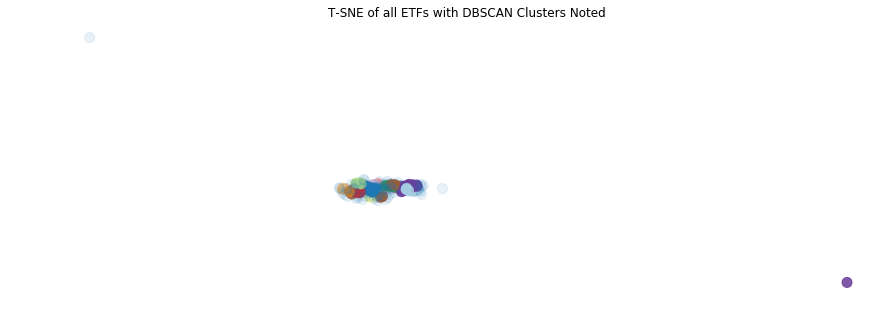

In [30]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

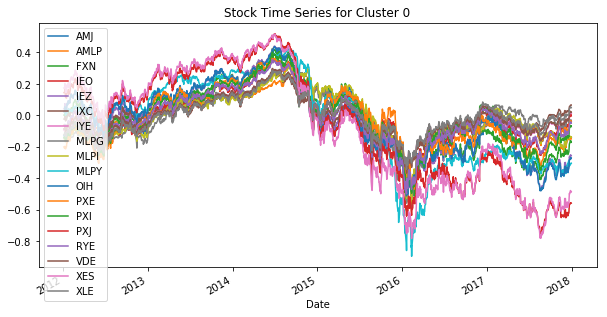

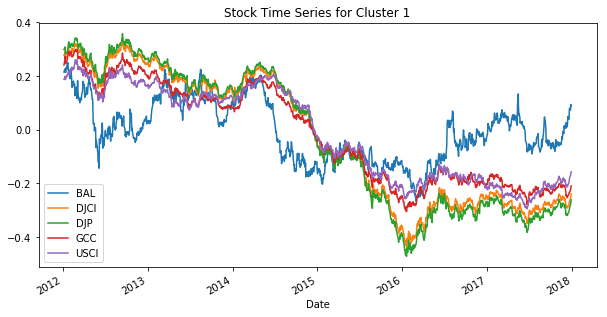

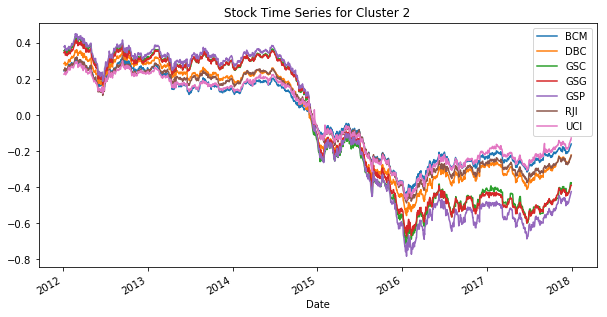

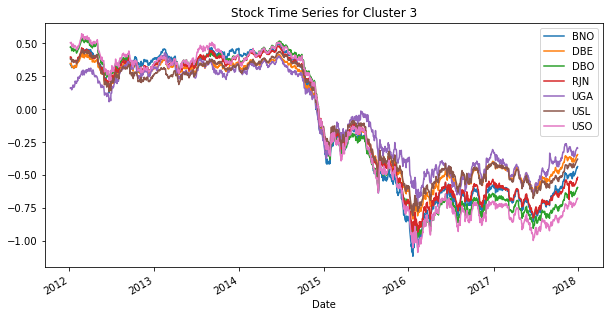

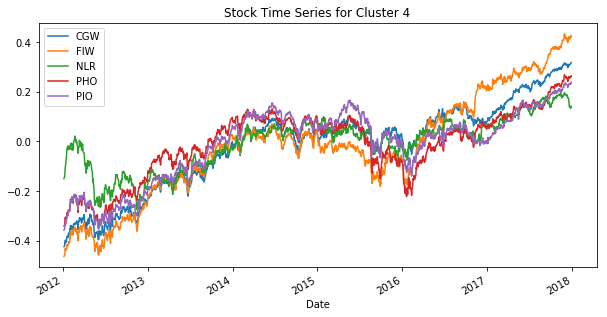

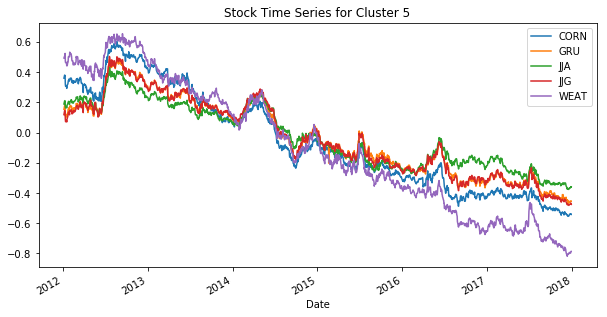

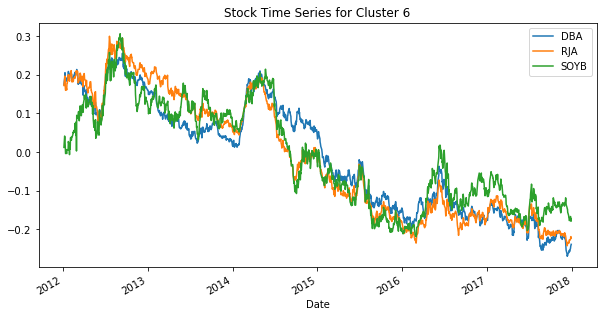

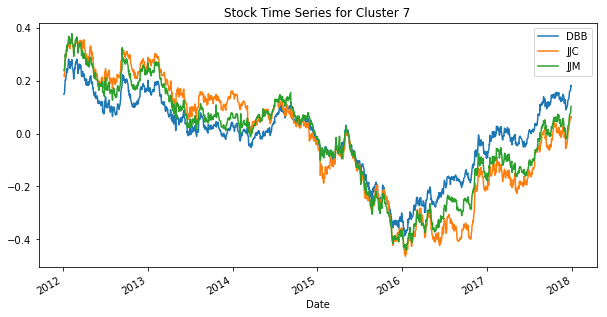

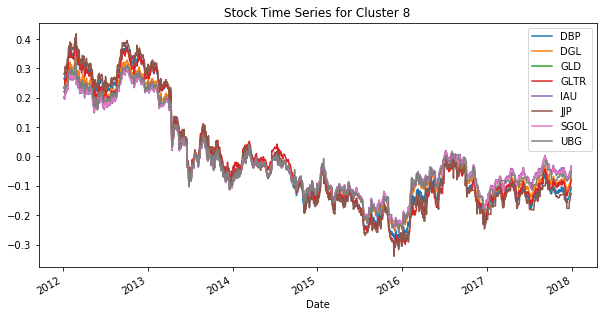

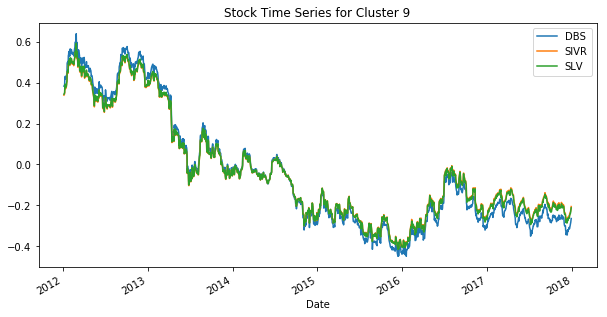

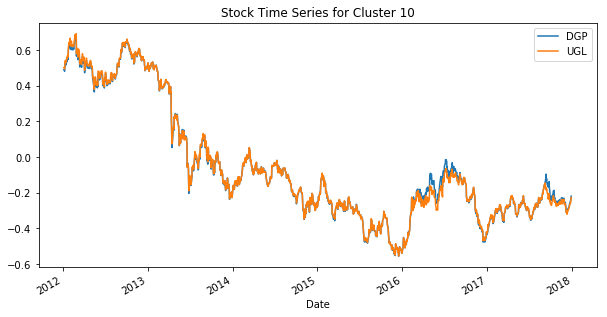

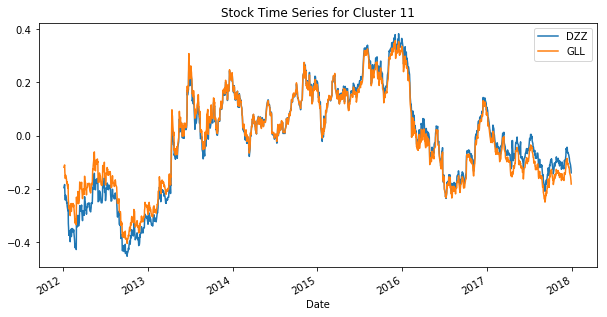

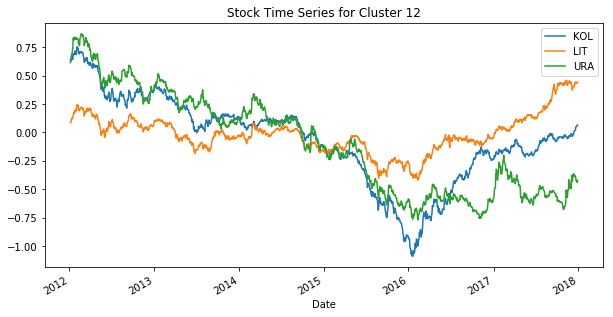

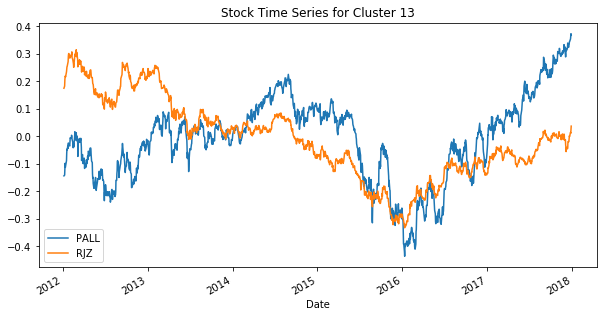

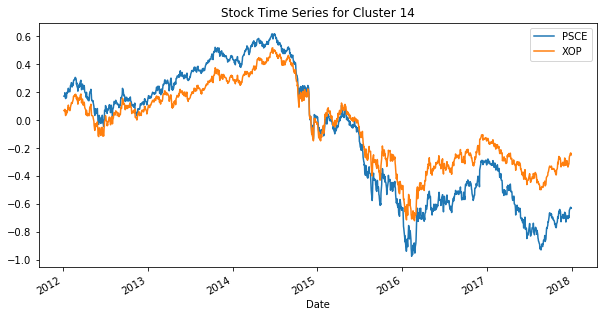

In [41]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices[symbols].mean())
    series = np.log(df_prices[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [42]:
total_pairs, unique_tickers = series_analyzer.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df=df_prices,
                                                            n_clusters=len(counts),
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 50 pairs
The pairs contain 49 unique tickers


In [152]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

**Applying Bollinger Bands**

In [153]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(total_pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



FXN,MLPY
APR -0.24824190694734438
Sharpe -0.8174046021407912


FXN,PXE
APR -0.10513099332169784
Sharpe -0.926494411046785


IEO,IYE
APR -0.09139310947739987
Sharpe -1.1186249713208574


IEO,MLPG
APR 0.316793349781024
Sharpe 1.070986248192517


IEZ,MLPY
APR -0.07552566529669447
Sharpe -0.12147579146638143


IYE,MLPG
APR 0.11364380109889427
Sharpe 0.5525396298356022


MLPG,VDE
APR 0.2830042338098926
Sharpe 1.1230293624932062


MLPG,XLE
APR 0.0919592470102002
Sharpe 0.4788139199430613


MLPY,OIH
APR 0.09563427515437772
Sharpe 0.4586685491708777


MLPY,PXE
APR 0.2534408753326054
Sharpe 1.0050075658441662


PXI,RYE
APR -0.01964063868917265
Sharpe -0.11160708491204954


BAL,DJCI
APR 0.43043367785538966
Sharpe 1.3919089380340528


BAL,DJP
APR 0.39995009169877704
Sharpe 1.3131554457856456


BAL,GCC
APR 0.32511190810092994
Sharpe 1.2366741662287153


BAL,USCI
APR -0.1047720758460744
Sharpe -0.2746046179660783


DJCI,GCC
APR 0.08444336890906401
Sharpe 0.9506927054274231


DJP,GCC
APR 0.0373932

**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  0.4061692533508492


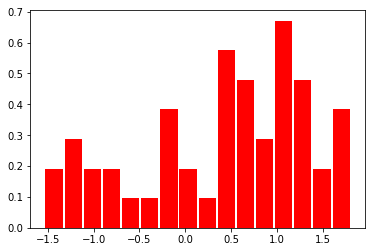

In [104]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

Sharpe Ratio Results: 
Average result:  0.4061692533508492


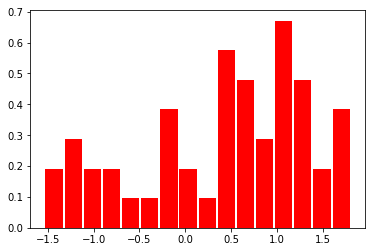

In [154]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

In [105]:
n_years= round(len(df_prices)/240)
total_roi_bollinger = np.mean(cum_returns_bollinger)
anual_roi_bollinger = ((1+(total_roi_bollinger/100))**(1/float(n_years))-1)*100
print('ROI: ', total_roi_bollinger)
print('Anual return:', anual_roi_bollinger)

ROI:  9.005842590358123
Anual return: 1.4475654802754256


**Applying the Kalman filter based strategy**

In [143]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']

sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(total_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter)



FXN,MLPY
APR 0.9299242018041258
Sharpe 3.067392461023279
Length before position returns:  1506
Length before shift:  1506
Length before Date:  1506


FXN,PXE
APR 0.04349757461786319
Sharpe 0.7113207926127438
Length before position returns:  1506
Length before shift:  1506
Length before Date:  1506


IEO,IYE
APR -0.015417023985304534
Sharpe -0.5213330318862033
Length before position returns:  1506
Length before shift:  1506
Length before Date:  1506


IEO,MLPG
APR 0.4841256969045886
Sharpe 2.9744401366584756
Length before position returns:  1506
Length before shift:  1506
Length before Date:  1506


IEZ,MLPY
APR 0.31494574086673666
Sharpe 1.1952641128192085
Length before position returns:  1506
Length before shift:  1506
Length before Date:  1506


IYE,MLPG
APR 1.1951443109523416
Sharpe 4.26334063240667
Length before position returns:  1506
Length before shift:  1506
Length before Date:  1506


MLPG,VDE
APR 1.5933128828278096
Sharpe 4.831558047794474
Length before position returns:  1

KeyboardInterrupt: 

In [139]:
performance_kalman[0][1]

,pnl,ret,FXN,MLPY,e,sqrt(Q),current_position,position_return
Date,,,,,,,,
2012-01-06,NaN,0.000000,18.173883,8.490933,18.173883,0.031623,0.0,0.000000
2012-01-09,0.009144,0.000503,18.164740,8.496070,18.164740,0.091209,0.0,0.050313
2012-01-10,-0.284040,-0.008372,18.429716,8.485795,2.467550,0.095809,0.0,-0.837193
2012-01-11,0.206095,0.005671,18.082506,8.418943,0.062722,0.095215,0.0,0.567097
2012-01-12,0.115929,0.003228,17.844938,8.361496,-0.109010,0.094710,0.0,0.322842
2012-01-13,-0.111162,-0.003135,17.634779,8.314488,-0.123315,0.094300,0.0,-0.313538
2012-01-17,-0.101803,-0.002906,17.707880,8.398054,-0.115670,0.095177,0.0,-0.290558
2012-01-18,0.429453,0.012206,18.137333,8.398054,0.416684,0.095095,0.0,1.220606
2012-01-19,0.243445,0.006766,18.082506,8.486839,-0.197368,0.095977,0.0,0.676642


Sharpe Ratio Results: 
Average result:  2.0300921967123453


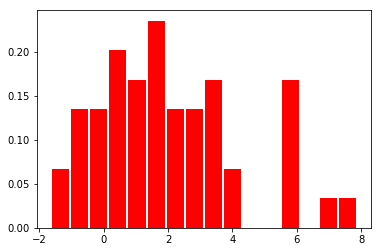

In [65]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))

In [83]:
n_years= round(len(df_prices)/240)
total_roi_kalman = np.mean(cum_returns_kalman)
annual_roi_kalman = ((1+(total_roi_kalman/100))**(1/float(n_years))-1)*100
print('ROI: ', total_roi_kalman)
print('Annual return:', annual_roi_kalman)

ROI:  45.54958286814363
Anual return: 6.455595623723243


In [133]:
len(performance_kalman[0][1])

1506

## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- Different time periods should be tested, to provide information on the variability of these results.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

**All against all** - *comparing against the simplest strategy*

In [201]:
no_cluster_series = pd.Series(0,index = etfs_pricing.columns)
total_pairs_all_a_all, unique_tickers = series_analyzer.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=1,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(total_pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 273 pairs
The pairs contain 41 unique tickers
Found 273 pairs


Bollinger Bands:

In [203]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

sharpe_results_boll_aaa, cum_returns_boll_aaa, performance_boll_aaa = trader.apply_bollinger_strategy(total_pairs_all_a_all,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



ALTY,DBV
APR -0.019690076598853357
Sharpe -0.37666046873915465


ALTY,DIVA
APR -0.025647640984403308
Sharpe -0.6268695474526955


ALTY,FLAT
APR 0.08703113849382382
Sharpe 2.030807685607455


ALTY,FUT
APR -0.00956969317643086
Sharpe -0.24988167683679713


ALTY,MRGR
APR -0.03981804664306354
Sharpe -1.0451248382719696


ALTY,SIZ
APR 0.04559781673716912
Sharpe 0.9427153906928085


ALTY,STPP
APR -0.04367292586973193
Sharpe -0.5331008817168248


ALTY,TVIX
APR 0.15845242756404643
Sharpe 1.115245313399877


ALTY,UVXY
APR 0.1815796270931438
Sharpe 1.2097981203596972


BTAL,DIVY
APR 0.017862582442937258
Sharpe 0.5720161966008018


BTAL,FUT
APR 0.029607195121189145
Sharpe 0.7547881999532214


BTAL,JPHF
APR 0.013638947462838669
Sharpe 0.448227225572819


CHEP,DIVA
APR 0.04564442310806638
Sharpe 0.8075868719931734


CHEP,DIVY
APR 0.023734801604629485
Sharpe 0.8278376545038248


CHEP,FTLS
APR -0.05475313592423159
Sharpe -0.5285461968372713


CHEP,FUT
APR 0.07843386895838855
Sharpe 0.95411644317309

APR 0.00018772807011280257
Sharpe 0.02526143334356859


DIVA,RINF
APR -0.045554115023159425
Sharpe -0.9852954618389087


DIVA,RLY
APR -0.01896471359405061
Sharpe -0.4051598950197042


DIVA,SIZ
APR 0.04684659395991919
Sharpe 0.9843676193258001


DIVA,STPP
APR 0.08510554058169872
Sharpe 1.4779415908917648


DIVA,TVIX
APR 0.04146312860638357
Sharpe 0.5933366926315745


DIVA,UVXY
APR 0.05205618217328323
Sharpe 0.734026628385942


DIVA,VEGA
APR -0.05642056614856672
Sharpe -1.564124480081488


DIVA,VIIX
APR 0.11407931714193853
Sharpe 1.9963207888977776


DIVA,VIXM
APR 0.10549016666101863
Sharpe 1.729224592760924


DIVA,VIXY
APR 0.10904664755240456
Sharpe 1.8996972497442384


DIVA,WTMF
APR 0.044035992860706585
Sharpe 1.149769501876805


DIVA,XVZ
APR 0.05254693458806314
Sharpe 1.122031104003971


DIVA,ZIV
APR -0.08165630755618969
Sharpe -1.4003938728604428


DIVY,DYB
APR -0.024569195016881595
Sharpe -0.9748186210390113


DIVY,FMF
APR -0.03682071366157491
Sharpe -1.2561063428888681


DIVY,MNA
A

APR -0.013264208326657423
Sharpe -0.2819939172430328


FUT,GAA
APR 0.03096986960422865
Sharpe 0.9009555733700528


FUT,HTUS
APR 0.02303278694396793
Sharpe 0.7388046003734902


FUT,JPHF
APR 0.04081425011189066
Sharpe 1.572016704331324


FUT,MCRO
APR 0.00807815069318174
Sharpe 0.297958642354598


FUT,MNA
APR -0.0033786845322384407
Sharpe -0.11191925393761408


FUT,MOM
APR 0.04525950443613991
Sharpe 1.2925014335620562


FUT,QAI
APR 0.01793785247566615
Sharpe 0.7177366576557209


FUT,QED
APR -0.05365952144185904
Sharpe -2.052228008273042


FUT,QLS
APR -0.015262384741230317
Sharpe -0.4599074662859895


FUT,QMN
APR 0.007898676507078983
Sharpe 0.33744439145744165


FUT,SIZ
APR -0.011701496822161261
Sharpe -0.27763578578786585


FUT,SVXY
APR -0.008735844000838489
Sharpe -0.18056608916994585


FUT,TVIX
APR -0.03348761812613865
Sharpe -0.701280205107946


FUT,UVXY
APR -0.03202798418065267
Sharpe -0.6713121003841697


FUT,VEGA
APR 0.01130011645109752
Sharpe 0.36898880399202194


FUT,VIIX
APR -0.0

APR -0.028810665304430882
Sharpe -1.2156909622290077


MNA,QMN
APR -0.033148208661512135
Sharpe -1.6304147225551633


MNA,SIZ
APR 0.011458415759262097
Sharpe 0.40091680518302564


MNA,STPP
APR -0.01104767493098513
Sharpe -0.35664442759613796


MNA,TVIX
APR -0.23912276535886245
Sharpe -1.199030258589216


MNA,UVXY
APR -0.28672377462857124
Sharpe -1.5504418831513092


MNA,VEGA
APR -0.024743814592359192
Sharpe -1.0502076686306336


MNA,VIIX
APR 0.03360939211634384
Sharpe 0.8987617039516559


MNA,VIXY
APR 0.031560052556113716
Sharpe 0.8232540108156807


MNA,XVZ
APR 0.022780270316132167
Sharpe 0.7999483838926853


MNA,ZIV
APR -0.05309244144173597
Sharpe -1.7050645354947593


MOM,QMN
APR -0.06338503702109777
Sharpe -2.1737886560424227


MOM,TVIX
APR -0.17228317345691957
Sharpe -0.5554809421259133


MOM,UVXY
APR -0.1987058073885467
Sharpe -0.7160483875003189


MOM,VEGA
APR -0.015207803828720112
Sharpe -0.3069874371281602


MRGR,QAI
APR -0.0218363270668418
Sharpe -1.098622853595885


MRGR,QED


APR 0.12781076619854614
Sharpe 0.967694694316533


TVIX,VIXM
APR -0.030107075046490128
Sharpe -0.16383633581407728


TVIX,XVZ
APR 0.11805659011942726
Sharpe 0.5190886067989029


UVXY,VEGA
APR 0.11959576123471938
Sharpe 0.9102157036559749


UVXY,VIXM
APR -0.0444710409582616
Sharpe -0.27552171159037575


UVXY,XVZ
APR 0.44063357459775543
Sharpe 1.0367498642915272


VEGA,VIXM
APR 0.09727167638303924
Sharpe 1.2950686313414943


VIIX,ZIV
APR -0.08401676285230242
Sharpe -0.8172407043595594


VIXY,ZIV
APR -0.13274753935170802
Sharpe -1.3632337600605549


Sharpe Ratio Results (considering entire universe): 
Average result:  -0.2182626320695486


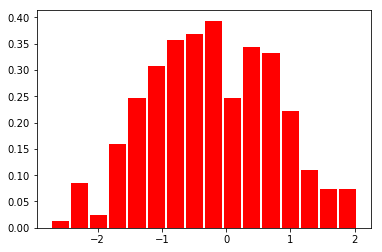

In [205]:
print('Sharpe Ratio Results (considering entire universe): ')
n, bins, patches = plt.hist(sharpe_results_boll_aaa, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_boll_aaa))

Kalman filter:

In [690]:
entry_multiplier=2
exit_multiplier=0.5

sharpe_results_kalman_all_a_all, cum_returns_kalman_all_all = apply_kalman_strategy(total_pairs_all_a_all,
                                                                                    entry_multiplier,
                                                                                    exit_multiplier)

NameError: name 'apply_kalman_strategy' is not defined

Sharpe Ratio Results (considering the entire universe): 
Average result:  0.2917998463678402


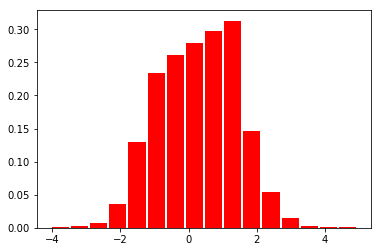

In [84]:
print('Sharpe Ratio Results (considering the entire universe): ')
n, bins, patches = plt.hist(sharpe_results_kalman_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman_all_a_all))

### Out of Sample Data

In this section, we pretend to analyze the performance of the algorithm in the validation dataset. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

In [130]:
len(performance_kalman[0][1])/240

6.275

In [ ]:
# Identified pairs under `unique_tickers`

initial_test_date = config['dataset']['testing_initial_date']
final_date = config['dataset']['testing_final_date']
error_counter = 0
dataset_ofs = {key: None for key in unique_tickers}
for ticker in unique_tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        series = df['Adj Close']; series.name = ticker # filter close price only
        dataset_ofs[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for '+ticker)

**Bollinger Bands Out-of-Sample**

In [ ]:
lookback_multiplier=2
sharpe_results_bollinger_ofs = []
returns_bollinger_ofs = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(dataset_ofs[coint_result['Y'].name],
                                                               dataset_ofs[coint_result['X'].name], 
                                                               lookback_multiplier*coint_result['half_life'],
                                                               entry_multiplier=2, exit_multiplier=0.5)
    returns_bollinger_ofs.append(ret)
    sharpe_results_bollinger_ofs.append(sharpe)

In [ ]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger_ofs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average Sharpe Ratio: ', np.mean(sharpe_results_bollinger_ofs))

It performs fairly poorly. Let's see how many of the identified pairs actually turned out to be cointegrated during this period.

### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

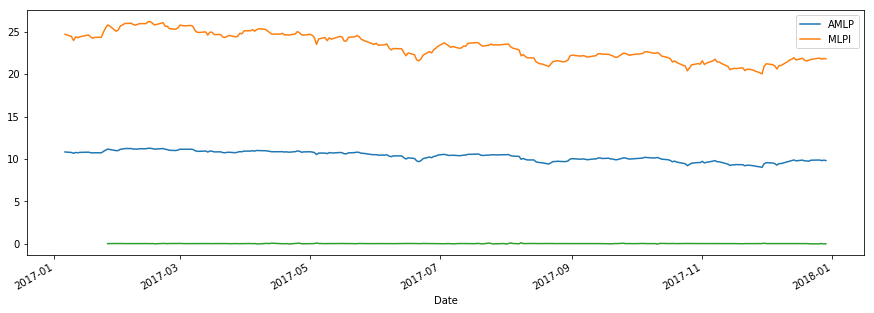

In [466]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [380]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

-0.04480324434678721


However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [376]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.021426798923804273


We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [108]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
negative_pairs_indices = np.argwhere(sharpe_results_kalman < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(total_pairs)))

9 out of 50 pairs turned out to be non-profitable


Let's get some more information on the non-profitable pairs:

In [109]:
negative_pairs = [total_pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

[('IEO', 'IYE'),
 ('BAL', 'GCC'),
 ('BAL', 'USCI'),
 ('DJP', 'GCC'),
 ('BNO', 'UGA'),
 ('DBE', 'UGA'),
 ('UGA', 'USL'),
 ('UGA', 'USO'),
 ('CORN', 'JJG')]

To what clusters do these pairs belong?

In [110]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

Pair ('IEO', 'IYE') belongs to cluster 0
Pair ('BAL', 'GCC') belongs to cluster 1
Pair ('BAL', 'USCI') belongs to cluster 1
Pair ('DJP', 'GCC') belongs to cluster 1
Pair ('BNO', 'UGA') belongs to cluster 3
Pair ('DBE', 'UGA') belongs to cluster 3
Pair ('UGA', 'USL') belongs to cluster 3
Pair ('UGA', 'USO') belongs to cluster 3
Pair ('CORN', 'JJG') belongs to cluster 5


How do the statistics rank?

In [111]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([total_pairs[index][0],
                 total_pairs[index][1],
                 total_pairs[index][2]['t_statistic'],
                 total_pairs[index][2]['p_value'],
                 total_pairs[index][2]['zero_cross'],
                 total_pairs[index][2]['half_life'],
                 total_pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive trades,negative_trades,sharpe_result
0,CORN,GRU,-3.404058,0.010821,104,28,0.419100,19,14,7.874875
1,RJN,USL,-2.988861,0.035948,114,35,0.439754,16,9,7.050578
2,RJA,SOYB,-4.474279,0.000219,98,21,0.360609,20,22,5.984475
3,RJN,USO,-3.351293,0.012736,95,37,0.439245,16,6,5.897631
4,JJC,JJM,-3.097372,0.026748,80,22,0.329256,24,15,5.699725
5,GRU,WEAT,-3.909307,0.001967,106,37,0.466337,16,7,5.586175
6,DBO,RJN,-3.365444,0.012195,115,30,0.427794,17,10,5.496269
7,DGP,UGL,-3.205752,0.019654,73,14,0.335867,39,28,3.986749
8,JJA,WEAT,-3.117105,0.025313,74,54,0.444761,7,7,3.866423
9,DJCI,GCC,-3.167705,0.021932,81,21,0.361562,27,14,3.568772


In [112]:
df.half_life.mean()

42.28

In [113]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Half-life vs Sharpe Ratio correlation:  -0.4545065959240087
Zero crossings vs Sharpe Ratio correlation:  0.41834257704466227
p-value vs Sharpe Ratio correlation:  0.02552538602418196
t-statistic vs Sharpe Ratio correlation:  0.09585827383877676
Hurst exponent vs Sharpe Ratio correlation  -0.07104130200064852


Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns